# DS4440 - Practical Neural Networks
## Understanding Two Tower Embedding Model and Contrastive Learning

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement  
In this notebook, we'll explore **Two-Tower Embedding Models** using a small-scale image-caption dataset. Two-tower models are a powerful architecture for **multimodal learning**, where the goal is to embed **images** and **text** into a shared semantic space.

### We will:  
- Build a **Two-Tower Model** that independently encodes images and text into a common embedding space  
- Understand how **contrastive learning** helps align image and text representations  
- Explore how this architecture can be used for **image-text retrieval**, **semantic similarity**, and **cross-modal search**

### What makes Two-Tower Models special?  
- They use **separate encoders** (CNN for images, Transformer for text) that learn independently but are trained jointly  
- They enable **efficient retrieval** by allowing precomputed embeddings for both modalities  
- They are trained with **contrastive loss**, which pulls positive image-text pairs together and pushes mismatched pairs apart  
- Two-tower models power state-of-the-art systems like **CLIP** and are highly scalable for multimodal tasks like **image captioning, visual search, and recommendation systems**


## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [1]:
! pip install -r requirements.txt

## 1. Data Gathering

### Flickr8k Dataset Overview

Flickr8k is a lightweight and well-structured dataset designed for image captioning and multimodal learning. It contains a curated collection of real-world images, each paired with multiple human-written captions, making it ideal for building and testing two-tower image-text embedding models.

### Dataset Details

- **Source:** Collected from the Flickr image-sharing platform
- **Content:** Natural scene images paired with descriptive captions
- **Size:** 8,000 images, each with 5 unique captions
- **Access:** Directly available via Hugging Face's `datasets` library

### Applications

Flickr8k is particularly suited for:
- **Contrastive Learning:** Training models to align visual and textual embeddings
- **Image-Text Retrieval:** Retrieving images from text queries or vice versa
- **Multimodal Representation Learning:** Building and evaluating two-tower models
- **Educational Demos:** Lightweight dataset ideal for rapid experimentation

### Advantages of Using Flickr8k

- **Small and Efficient:** Can be trained on CPU or small GPUs, perfect for prototyping
- **Multiple Captions per Image:** Enables strong positive pairs and diverse semantic learning
- **Ready-to-Use via Code:** No manual download required—can be loaded in a few lines of Python
- **Real-World Semantics:** Captures everyday scenes with diverse and natural language

### Accessing Flickr8k

You can load the dataset directly using the Hugging Face `datasets` library:

```python
from datasets import load_dataset

dataset = load_dataset("nlphuji/flickr8k", split="train")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer


### Load the Dataset


In [3]:


dataset = load_dataset("tsystems/flickr8k")

### Visualize an image and its respective caption

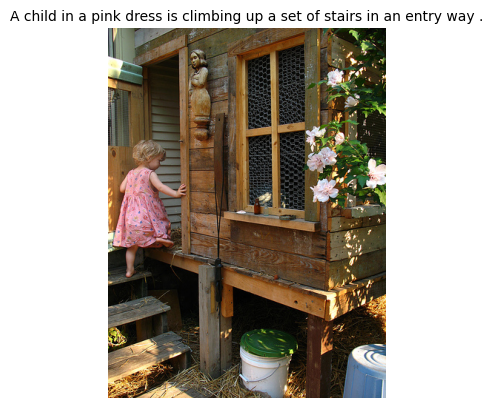

Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 2: A girl going into a wooden building .
Caption 3: A little girl climbing into a wooden playhouse .
Caption 4: A little girl climbing the stairs to her playhouse .
Caption 5: A little girl in a pink dress going into a wooden cabin .


In [4]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Get a sample
sample = dataset['train'][0]
image = sample['image']              # Already a PIL Image
captions = sample['captions']        # List of 5 captions
main_caption = sample['query']       # Primary caption (used for contrastive learning)

# Show the image and its main caption
plt.imshow(image)
plt.title(main_caption, fontsize=10)
plt.axis("off")
plt.show()

# Optional: Print all captions
for i, cap in enumerate(captions, 1):
    print(f"Caption {i}: {cap}")

#### Dataset Size

In [5]:
len(dataset)

1

## 2. Two-Tower Multimodal Embedding and Contrastive Learning

In this notebook, we'll explore the concept of **two-tower architectures** for learning shared embeddings between images and text using **contrastive learning**. This approach is a powerful foundation for multimodal tasks such as **image-text retrieval**, **visual search**, and **semantic alignment**.

### What is a Two-Tower Model?

A **two-tower model** consists of two separate encoders:
1. **Image Encoder** (e.g., ResNet, ViT): Converts input images into fixed-size embeddings.
2. **Text Encoder** (e.g., BERT): Converts input captions or queries into textual embeddings.

These two encoders work independently but are trained together to project both modalities into a **shared semantic space**.

### Contrastive Learning: Core Principle

At the heart of this approach is **contrastive learning**, which helps the model learn by comparing:
- **Positive Pairs**: Matching image-caption examples (e.g., an image of a dog and the caption "A dog running in the park")
- **Negative Pairs**: Mismatched examples (e.g., the same dog image and the caption "A car on the road")

The goal is to:
- **Pull positive pairs closer** in embedding space
- **Push negative pairs apart**

This is typically done using a **contrastive loss function** like **InfoNCE**, which encourages high similarity for matched pairs and low similarity for mismatches.

### How It Works

- **Image Tokenization**: Images are processed through a CNN or vision transformer to produce a dense vector embedding.
- **Text Tokenization**: Captions are tokenized using a text tokenizer (like BERT tokenizer) and passed through a transformer to obtain text embeddings.
- **Normalization**: Embeddings are often normalized to lie on a unit hypersphere.
- **Similarity Computation**: Cosine similarity is calculated between each image and text embedding in the batch.
- **Loss Optimization**: A contrastive loss is applied to align positive pairs and separate negatives.

### Why This Matters

- **Modality Bridging**: Learns a joint understanding of vision and language.
- **Scalable Retrieval**: Enables efficient image-to-text or text-to-image search using nearest neighbors in embedding space.
- **Zero-Shot Potential**: With enough data, these models can generalize to unseen image-caption pairs without fine-tuning.

### Summary

Two-tower multimodal models powered by contrastive learning are a robust and scalable way to connect visual and linguistic information. By learning a common embedding space, they enable cross-modal applications such as retrieval, search, and recommendation.



### Build the Dataset

In [6]:
class Flickr8kDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, image_transform, max_length=32):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Image is already a PIL object
        image = self.image_transform(sample['image'])

        # 'query' contains the main caption to tokenize
        caption = sample['query']
        encoding = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


In [7]:


split = dataset['train'].train_test_split(test_size=0.1, seed=42)

# Tokenizer and transform
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset objects
train_set = Flickr8kDataset(split['train'], tokenizer, image_transform)
test_set = Flickr8kDataset(split['test'], tokenizer, image_transform)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

### Build the Two Tower Model

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel

class ImageTower(nn.Module):
    def __init__(self, embed_dim=256):
        super(ImageTower, self).__init__()
        # Use a pretrained ResNet50 as the image encoder
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification head
        self.project = nn.Linear(2048, embed_dim)  # Project to shared embedding space

    def forward(self, images):
        features = self.backbone(images)         # [B, 2048]
        embed = self.project(features)           # [B, embed_dim]
        return nn.functional.normalize(embed, dim=-1)  # L2 normalize


class TextTower(nn.Module):
    def __init__(self, embed_dim=256):
        super(TextTower, self).__init__()
        # Use pretrained BERT as the text encoder
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.project = nn.Linear(self.bert.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.pooler_output  # [B, hidden_size]
        embed = self.project(cls_embedding)    # [B, embed_dim]
        return nn.functional.normalize(embed, dim=-1)  # L2 normalize


class TwoTowerModel(nn.Module):
    def __init__(self, embed_dim=256):
        super(TwoTowerModel, self).__init__()
        self.image_encoder = ImageTower(embed_dim)
        self.text_encoder = TextTower(embed_dim)

    def forward(self, images, input_ids, attention_mask):
        image_embeddings = self.image_encoder(images)
        text_embeddings = self.text_encoder(input_ids, attention_mask)
        return image_embeddings, text_embeddings


### Visualize how the embeddings look when image and text is passed through the two tower model

In [9]:

device = torch.device("mps")
# Make sure the model is in eval mode and moved to the right device
model = TwoTowerModel(embed_dim=256).to(device)
model.eval()

# Pick a sample from the test set
sample = test_set[24]

# Prepare inputs
image = sample['image'].unsqueeze(0).to(device)             # [1, 3, 224, 224]
input_ids = sample['input_ids'].unsqueeze(0).to(device)     # [1, L]
attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

# Forward pass without gradients
with torch.no_grad():
    image_embed, text_embed = model(image, input_ids, attention_mask)

# Convert embeddings to numpy
image_vec = image_embed.squeeze(0).cpu().numpy()
text_vec = text_embed.squeeze(0).cpu().numpy()



/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### You can now add the embeddings to get embeddings for the image and text

In [10]:
image_vec + text_vec

array([-1.72534227e-01, -9.83459055e-02, -6.47955686e-02, -8.09539780e-02,
        1.14525549e-01, -8.40139836e-02,  1.01982087e-01,  4.75726612e-02,
       -4.48889956e-02, -1.99864417e-01,  8.61025602e-02,  8.42485800e-02,
       -1.53325319e-01,  2.79784575e-02, -3.86527628e-02, -4.43198532e-03,
       -1.02221966e-04, -7.68263340e-02,  8.65905583e-02,  7.13575333e-02,
        2.24241745e-02,  1.31850615e-02, -9.20342952e-02, -1.58793405e-01,
       -1.43930241e-01,  4.17411253e-02,  7.86662698e-02,  7.14817494e-02,
        6.56785965e-02,  4.70262766e-02,  4.96951491e-02,  1.00137927e-02,
        4.56800573e-02, -2.97780465e-02, -1.42441802e-02,  1.19648159e-01,
        7.85983279e-02,  5.52770644e-02,  5.88819720e-02,  1.10893548e-01,
        8.01001862e-02, -2.84842253e-02,  1.01812795e-01, -1.27550429e-02,
        1.38278648e-01, -1.82415649e-01,  2.79656686e-02, -2.05718279e-02,
        1.76272720e-01,  8.54656249e-02, -2.35830918e-02,  1.75235465e-01,
       -5.95450401e-03, -

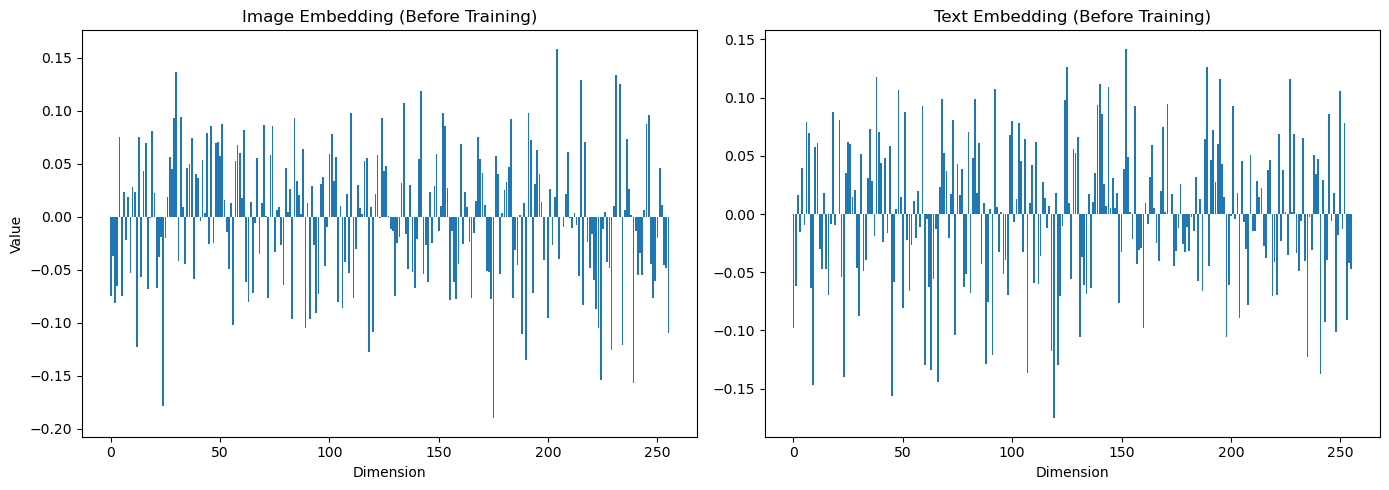

In [11]:
# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(image_vec)), image_vec)
plt.title("Image Embedding (Before Training)")
plt.xlabel("Dimension")
plt.ylabel("Value")

plt.subplot(1, 2, 2)
plt.bar(range(len(text_vec)), text_vec)
plt.title("Text Embedding (Before Training)")
plt.xlabel("Dimension")

plt.tight_layout()
plt.show()


## 3. Contrastive Loss

In [12]:
import torch.nn.functional as F

def contrastive_loss(image_embeds, text_embeds, temperature=0.07):
    # Normalize embeddings
    image_embeds = F.normalize(image_embeds, dim=1)
    text_embeds = F.normalize(text_embeds, dim=1)

    # Cosine similarity matrix [B, B]
    logits = image_embeds @ text_embeds.T
    logits /= temperature

    # Targets: diagonal (each image ↔ its matching caption)
    labels = torch.arange(logits.shape[0]).to(logits.device)

    loss_i2t = F.cross_entropy(logits, labels)      # image → text
    loss_t2i = F.cross_entropy(logits.T, labels)    # text → image

    return (loss_i2t + loss_t2i) / 2


## 4. Training

In [13]:
from tqdm import tqdm

def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        image_embeds, text_embeds = model(images, input_ids, attention_mask)

        # Contrastive loss
        loss = contrastive_loss(image_embeds, text_embeds)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Average Training Loss: {avg_loss:.4f}")


In [14]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TwoTowerModel(embed_dim=256).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
epochs = 1
# Train for 5 epochs
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    train(model, train_loader, optimizer, device)



Epoch 1


Training: 100%|██████████| 456/456 [42:45<00:00,  5.63s/it] 

Average Training Loss: 1.7072


## 5. Inference

In [24]:
def compute_image_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_images = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            image_embeds = model.image_encoder(images)
            all_embeddings.append(image_embeds.cpu())
            all_images.extend(batch['image'])  # Keep raw (or normalized) images

    return torch.cat(all_embeddings), all_images

In [25]:
def encode_text(model, tokenizer, text, device, max_length=32):
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        text_embed = model.text_encoder(input_ids, attention_mask)

    return text_embed.cpu()

In [26]:
def find_matching_image(query_text, model, tokenizer, image_embeddings, image_refs, device):
    text_embed = encode_text(model, tokenizer, query_text, device)
    sims = F.cosine_similarity(text_embed, image_embeddings)  # [num_images]
    best_idx = torch.argmax(sims).item()
    return image_refs[best_idx], sims[best_idx].item()

In [29]:
from torchvision.transforms import ToPILImage

def show_result(image_tensor, score, query):
    # Convert [3, 224, 224] → PIL
    image = ToPILImage()(image_tensor.cpu())

    # Plot
    plt.imshow(image)
    plt.title(f"Query: {query}\nMatch Score: {score:.4f}", fontsize=10)
    plt.axis("off")
    plt.show()


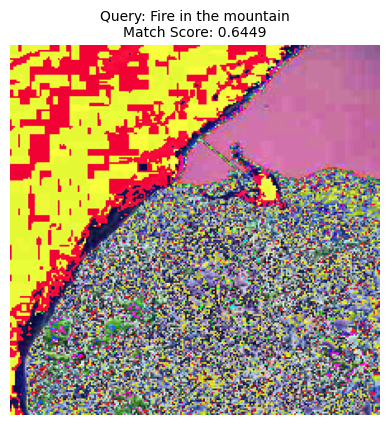

In [33]:
image_embeddings, image_refs = compute_image_embeddings(model, test_loader, device)

# Example text query
query = "Fire in the mountain"

# Find best match
matched_image, score = find_matching_image(query, model, tokenizer, image_embeddings, image_refs, device)

# Show result
show_result(matched_image, score, query)